In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass


In [2]:
from gemseo import configure_logger
from gemseo.algos.design_space import DesignSpace
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.scenarios.mdo_scenario import MDOScenario
from gemseo.disciplines.auto_py import AutoPyDiscipline
from numpy import array
from gemseo_oad_training.unit import convert_from

In [3]:
configure_logger()

<RootLogger root (INFO)>

**Création des disciplines**

In [4]:
l_disciplines = []
l_disciplines.append(AutoPyDiscipline(aerodynamic))
l_disciplines.append(AutoPyDiscipline(approach))
l_disciplines.append(AutoPyDiscipline(battery))
l_disciplines.append(AutoPyDiscipline(climb))
l_disciplines.append(AutoPyDiscipline(engine))
l_disciplines.append(AutoPyDiscipline(fuel_tank))
l_disciplines.append(AutoPyDiscipline(geometry))
l_disciplines.append(AutoPyDiscipline(mass))
l_disciplines.append(AutoPyDiscipline(mission))
l_disciplines.append(AutoPyDiscipline(operating_cost))
l_disciplines.append(AutoPyDiscipline(take_off))
l_disciplines.append(AutoPyDiscipline(total_mass))

**Création du desgin space**

In [5]:
class DesignSpacePB1(DesignSpace):
    def __init__(self):
        super().__init__(name="DSPB1")
        self.add_variable("slst", lower_bound=convert_from("kN",100), upper_bound=convert_from("kN",200), value=convert_from("kN",150.))
        self.add_variable("n_pax", lower_bound=120., upper_bound=180., value=150.)
        self.add_variable("area", lower_bound=convert_from("m2",100.), upper_bound=convert_from("m2",200.), value=convert_from("m2",180.))
        self.add_variable("ar", lower_bound=5, upper_bound=20., value=9.)


In [6]:
from utils import update_default_inputs
x_def = {'fuel_type' : 'liquid_h2', 'engine_type' : 'turbofan', 'design_range' : 5500000}
update_default_inputs(l_disciplines, x_def)

In [7]:
design_space_pb1 = DesignSpacePB1()

In [8]:
design_space_pb1

Name,Lower bound,Value,Upper bound,Type
slst,100000,150000,200000,float
n_pax,120,150,180,float
area,100,180,200,float
ar,5,9,20,float


In [9]:
scenario = MDOScenario(l_disciplines, "mtom", design_space_pb1, formulation_name="MDF")
scenario.add_constraint("tofl", constraint_type="ineq", positive=False,value=convert_from("m", 1900))
scenario.add_constraint("vapp", constraint_type="ineq", positive=False, value=convert_from("kt", 135))
scenario.add_constraint("vz", constraint_type="ineq", positive=True, value=convert_from("ft/min", 300))
scenario.add_constraint("span", constraint_type="ineq", positive=False, value=convert_from("m", 40))
scenario.add_constraint("length", constraint_type="ineq", positive=False, value=convert_from("m", 45))
scenario.add_constraint("fm", constraint_type="ineq", positive=True, value=0)
scenario.add_constraint("fm", constraint_type="ineq", positive=False, value=100)




In [10]:
scenario.execute(algo_name="NLOPT_COBYLA", max_iter=20)

    INFO - 17:11:39: *** Start MDOScenario execution ***
    INFO - 17:11:39: MDOScenario
    INFO - 17:11:39:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:11:39:    MDO formulation: MDF
    INFO - 17:11:39: Optimization problem:
    INFO - 17:11:39:    minimize mtom(slst, n_pax, area, ar)
    INFO - 17:11:39:    with respect to ar, area, n_pax, slst
    INFO - 17:11:39:    subject to constraints:
    INFO - 17:11:39:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 17:11:39:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 17:11:39:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 17:11:39:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 17:11:39:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 17:11:39:       fm(slst, n_pax, area, ar) >= 0
    INFO - 17:11:39:       fm(slst, n_pax, area, ar) <= 100
    INFO - 17:11:39:    over the design space:
    INFO 

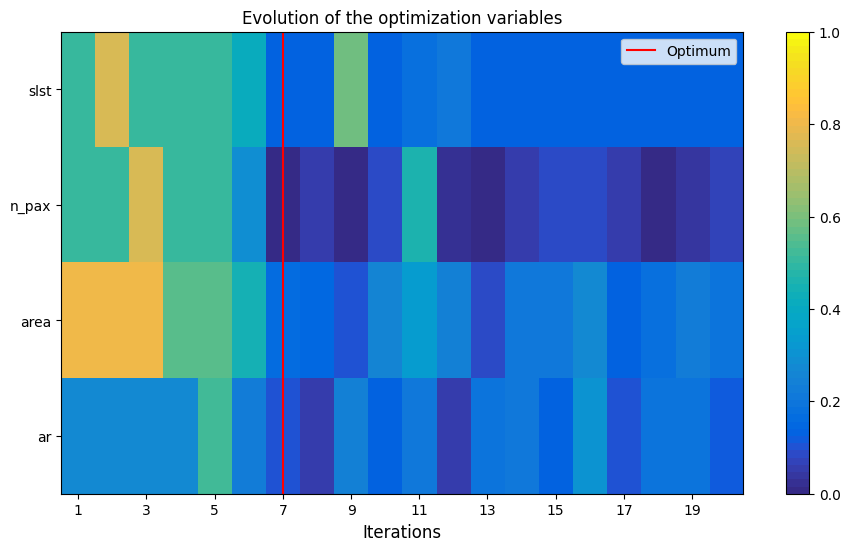

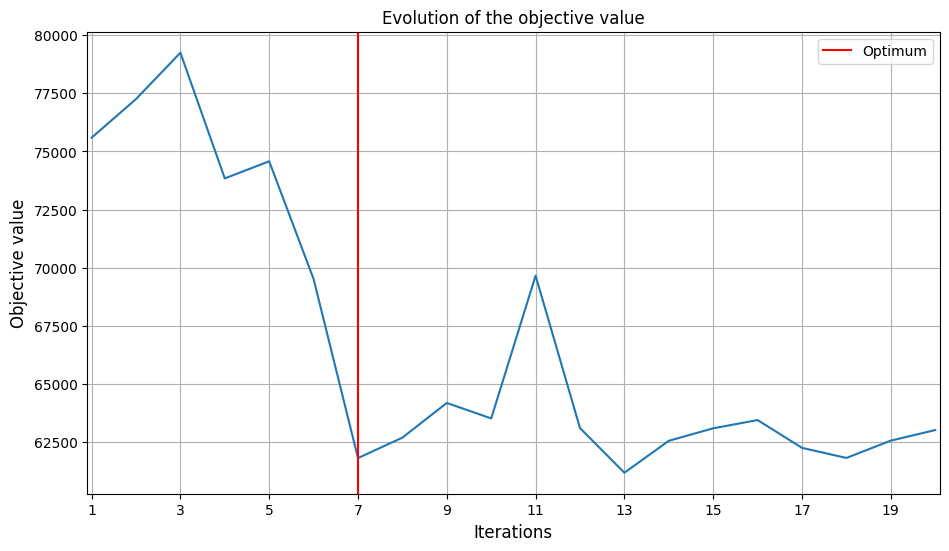

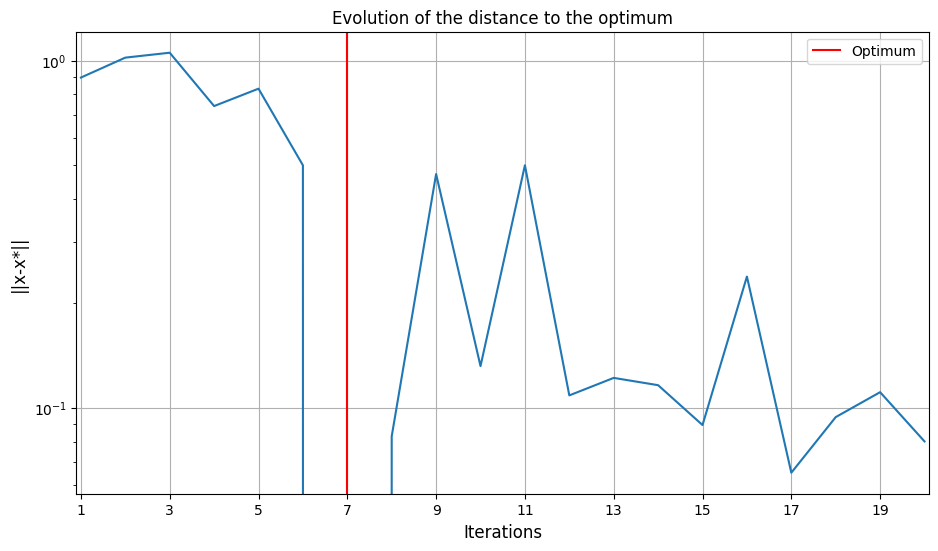

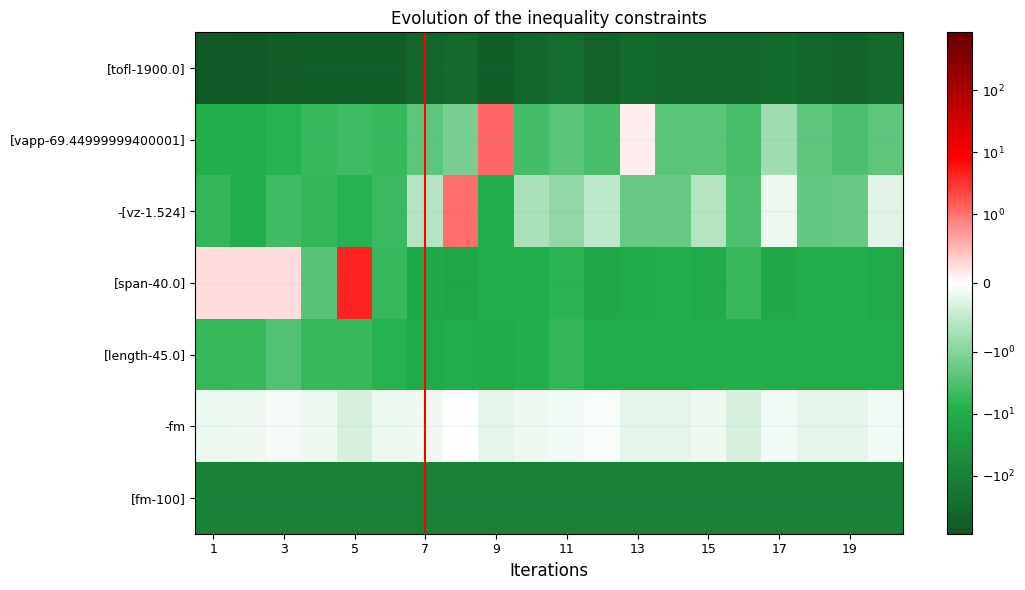

In [11]:
scenario.post_process(post_name="OptHistoryView", save=False, show=True)

Pour la suite : utiliser à la place des discipline s, smaple_discplines() -> "OT_OPT_LHS"  ou sobol ou halton
renvoye une surogate discpiline et remplacer dans MDO scenario la liste des discplines par la sugorate discpline

Surrogate

In [12]:
from gemseo.disciplines.surrogate import SurrogateDiscipline
from gemseo import sample_disciplines

In [13]:
training_dataset = sample_disciplines(l_disciplines, design_space_pb1, ["mtom", "tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_OPT_LHS", n_samples=20)

    INFO - 17:11:42: *** Start Sampling execution ***
    INFO - 17:11:42: Sampling
    INFO - 17:11:42:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:11:42:    MDO formulation: MDF
    INFO - 17:11:42: Running the algorithm OT_OPT_LHS:
    INFO - 17:11:43:    100%|██████████| 20/20 [00:01<00:00, 19.70 it/sec]
    INFO - 17:11:43: *** End Sampling execution (time: 0:00:01.029517) ***


In [14]:
test_dataset = sample_disciplines(l_disciplines, design_space_pb1, ["mtom", "tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_FULLFACT", n_samples=30)

    INFO - 17:11:43: *** Start Sampling execution ***
    INFO - 17:11:43: Sampling
    INFO - 17:11:43:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:11:43:    MDO formulation: MDF
    INFO - 17:11:43: Running the algorithm OT_FULLFACT:
    INFO - 17:11:43:    100%|██████████| 16/16 [00:00<00:00, 20.55 it/sec]s not exist; use 16 samples instead, i.e. the largest 4-th integer power less than 30.
    INFO - 17:11:43: *** End Sampling execution (time: 0:00:00.785637) ***


In [44]:
# Liste des surrogate models à tester
metamodels = [
    'GaussianProcessRegressor',
    'GradientBoostingRegressor',
    'LinearRegressor',
    'MLPRegressor',
    'PolynomialRegressor', 
    'RandomForestRegressor',
]

results = {}

for model_name in metamodels:
    print(f"model: {model_name}")

    # Créer la discipline de substitution
    surrogate_discipline = SurrogateDiscipline(model_name, training_dataset)

    # Définir un scénario MDO avec cette discipline
    scenario_surrogate = MDOScenario(
        [surrogate_discipline],
        formulation_name="MDF",
        objective_name="mtom",
        design_space=design_space_pb1
    )

    # Ajouter les contraintes
    scenario_surrogate.add_constraint("tofl", constraint_type="ineq", positive=False, value=convert_from("m", 1900))
    scenario_surrogate.add_constraint("vapp", constraint_type="ineq", positive=False, value=convert_from("kt", 135))
    scenario_surrogate.add_constraint("vz", constraint_type="ineq", positive=True, value=convert_from("ft/min", 300))
    scenario_surrogate.add_constraint("span", constraint_type="ineq", positive=False, value=convert_from("m", 40))
    scenario_surrogate.add_constraint("length", constraint_type="ineq", positive=False, value=convert_from("m", 45))
    scenario_surrogate.add_constraint("fm", constraint_type="ineq", positive=True, value=0)
    scenario_surrogate.add_constraint("fm", constraint_type="ineq", positive=False, value=100)

    # Exécuter l'optimisation
    scenario_surrogate.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    # Évaluer la qualité via R² en validation croisée
    r2 = surrogate_discipline.get_error_measure("R2Measure")
    r2_result = r2.compute_test_measure(test_dataset, as_dict=True)

    results[model_name] = r2_result
    print(f" {model_name} -> R² (CV): {r2_result}")

# Affichage final des résultats
print("\n Résultats du benchmark R² :")
for model, score in results.items():
    print(f"{model:12} : {score}")


model: GaussianProcessRegressor


 WARNING - 17:31:28: No coupling in MDA, switching chain_linearize to True.
    INFO - 17:31:28: *** Start MDOScenario execution ***
    INFO - 17:31:28: MDOScenario
    INFO - 17:31:28:    Disciplines: GPR_Sampling
    INFO - 17:31:28:    MDO formulation: MDF
    INFO - 17:31:28: Optimization problem:
    INFO - 17:31:28:    minimize mtom(slst, n_pax, area, ar)
    INFO - 17:31:28:    with respect to ar, area, n_pax, slst
    INFO - 17:31:28:    subject to constraints:
    INFO - 17:31:28:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 17:31:28:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 17:31:28:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 17:31:28:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 17:31:28:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 17:31:28:       fm(slst, n_pax, area, ar) >= 0
    INFO - 17:31:28:       fm(slst, n_pax, area, ar) <= 100
    INFO - 17:31:28:    over the design space:
    INFO - 17:31:28:       +-

 GaussianProcessRegressor -> R² (CV): {'fm': array([0.93771029]), 'length': array([0.93018709]), 'mtom': array([0.90867184]), 'span': array([0.93708347]), 'tofl': array([0.77092532]), 'vapp': array([0.94077607]), 'vz': array([0.89866559])}
model: GradientBoostingRegressor


 WARNING - 17:31:29: No coupling in MDA, switching chain_linearize to True.
    INFO - 17:31:29: *** Start MDOScenario execution ***
    INFO - 17:31:29: MDOScenario
    INFO - 17:31:29:    Disciplines: GradientBoostingRegressor_Sampling
    INFO - 17:31:29:    MDO formulation: MDF
    INFO - 17:31:29: Optimization problem:
    INFO - 17:31:29:    minimize mtom(slst, n_pax, area, ar)
    INFO - 17:31:29:    with respect to ar, area, n_pax, slst
    INFO - 17:31:29:    subject to constraints:
    INFO - 17:31:29:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 17:31:29:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 17:31:29:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 17:31:29:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 17:31:29:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 17:31:29:       fm(slst, n_pax, area, ar) >= 0
    INFO - 17:31:29:       fm(slst, n_pax, area, ar) <= 100
    INFO - 17:31:29:    over the design space:
    INF

 GradientBoostingRegressor -> R² (CV): {'fm': array([0.79100255]), 'length': array([0.98555573]), 'mtom': array([0.80118429]), 'span': array([0.93031999]), 'tofl': array([0.46664133]), 'vapp': array([0.87451346]), 'vz': array([0.76180137])}
model: LinearRegressor


    INFO - 17:31:31:    100%|██████████| 100/100 [00:00<00:00, 129.07 it/sec, obj=5.95e+4]
    INFO - 17:31:31: Optimization result:
    INFO - 17:31:31:    Optimizer info:
    INFO - 17:31:31:       Status: None
    INFO - 17:31:31:       Message: Maximum number of iterations reached. GEMSEO stopped the driver.
    INFO - 17:31:31:       Number of calls to the objective function by the optimizer: 102
    INFO - 17:31:31:    Solution:
    INFO - 17:31:31:       The solution is feasible.
    INFO - 17:31:31:       Objective: 59487.20653600729
    INFO - 17:31:31:       Standardized constraints:
    INFO - 17:31:31:          -[vz-1.524] = -0.0
    INFO - 17:31:31:          -fm = -0.07866937585107968
    INFO - 17:31:31:          [fm-100] = -99.92133062414892
    INFO - 17:31:31:          [length-45.0] = -10.25
    INFO - 17:31:31:          [span-40.0] = -16.84248922131704
    INFO - 17:31:31:          [tofl-1900.0] = -262.7680921452063
    INFO - 17:31:31:          [vapp-69.4499999940000

 LinearRegressor -> R² (CV): {'fm': array([0.95072157]), 'length': array([1.]), 'mtom': array([0.97022664]), 'span': array([0.96030547]), 'tofl': array([0.78003495]), 'vapp': array([0.95855152]), 'vz': array([0.89829262])}
model: MLPRegressor


    INFO - 17:31:32:    100%|██████████| 100/100 [00:00<00:00, 110.20 it/sec, obj=6.17e+4]
    INFO - 17:31:32: Optimization result:
    INFO - 17:31:32:    Optimizer info:
    INFO - 17:31:32:       Status: None
    INFO - 17:31:32:       Message: Maximum number of iterations reached. GEMSEO stopped the driver.
    INFO - 17:31:32:       Number of calls to the objective function by the optimizer: 102
    INFO - 17:31:32:    Solution:
    INFO - 17:31:32:       The solution is feasible.
    INFO - 17:31:32:       Objective: 61689.1113113944
    INFO - 17:31:32:       Standardized constraints:
    INFO - 17:31:32:          -[vz-1.524] = -0.0
    INFO - 17:31:32:          -fm = -0.005924162787991791
    INFO - 17:31:32:          [fm-100] = -99.99407583721201
    INFO - 17:31:32:          [length-45.0] = -9.048391692215311
    INFO - 17:31:32:          [span-40.0] = -12.196227961705269
    INFO - 17:31:32:          [tofl-1900.0] = -595.9800876612383
    INFO - 17:31:32:          [vapp-69.

 MLPRegressor -> R² (CV): {'fm': array([0.83621768]), 'length': array([0.97601419]), 'mtom': array([0.91754863]), 'span': array([0.86743462]), 'tofl': array([0.54912145]), 'vapp': array([0.69337758]), 'vz': array([0.88794579])}
model: PolynomialRegressor


    INFO - 17:31:33:    100%|██████████| 100/100 [00:00<00:00, 117.22 it/sec, obj=6.05e+4]
    INFO - 17:31:33: Optimization result:
    INFO - 17:31:33:    Optimizer info:
    INFO - 17:31:33:       Status: None
    INFO - 17:31:33:       Message: Maximum number of iterations reached. GEMSEO stopped the driver.
    INFO - 17:31:33:       Number of calls to the objective function by the optimizer: 102
    INFO - 17:31:33:    Solution:
    INFO - 17:31:33:       The solution is feasible.
    INFO - 17:31:33:       Objective: 60469.95129670995
    INFO - 17:31:33:       Standardized constraints:
    INFO - 17:31:33:          -[vz-1.524] = -0.5938373369825998
    INFO - 17:31:33:          -fm = -0.3388188173132581
    INFO - 17:31:33:          [fm-100] = -99.66118118268675
    INFO - 17:31:33:          [length-45.0] = -10.250000000000007
    INFO - 17:31:33:          [span-40.0] = -7.835970428827068
    INFO - 17:31:33:          [tofl-1900.0] = -143.89773120485347
    INFO - 17:31:33:    

 PolynomialRegressor -> R² (CV): {'fm': array([0.99815955]), 'length': array([1.]), 'mtom': array([0.99652477]), 'span': array([0.99849626]), 'tofl': array([0.96722124]), 'vapp': array([0.99703911]), 'vz': array([0.97994055])}
model: RandomForestRegressor


    INFO - 17:31:33:     33%|███▎      | 33/100 [00:00<00:01, 60.02 it/sec, obj=6.67e+4]
    INFO - 17:31:33: Optimization result:
    INFO - 17:31:33:    Optimizer info:
    INFO - 17:31:33:       Status: None
    INFO - 17:31:33:       Message: Successive iterates of the objective function are closer than ftol_rel or ftol_abs. GEMSEO stopped the driver.
    INFO - 17:31:33:       Number of calls to the objective function by the optimizer: 36
    INFO - 17:31:33:    Solution:
    INFO - 17:31:33:       The solution is feasible.
    INFO - 17:31:33:       Objective: 66724.85769648451
    INFO - 17:31:33:       Standardized constraints:
    INFO - 17:31:33:          -[vz-1.524] = -6.5022910014414075
    INFO - 17:31:33:          -fm = -0.280206488017029
    INFO - 17:31:33:          [fm-100] = -99.71979351198297
    INFO - 17:31:33:          [length-45.0] = -8.772103635452332
    INFO - 17:31:33:          [span-40.0] = -4.178057864732118
    INFO - 17:31:33:          [tofl-1900.0] = -55

 RandomForestRegressor -> R² (CV): {'fm': array([0.62177722]), 'length': array([0.71189808]), 'mtom': array([0.57817953]), 'span': array([0.61381989]), 'tofl': array([0.34784582]), 'vapp': array([0.49850859]), 'vz': array([0.4763407])}

 Résultats du benchmark R² :
GaussianProcessRegressor : {'fm': array([0.93771029]), 'length': array([0.93018709]), 'mtom': array([0.90867184]), 'span': array([0.93708347]), 'tofl': array([0.77092532]), 'vapp': array([0.94077607]), 'vz': array([0.89866559])}
GradientBoostingRegressor : {'fm': array([0.79100255]), 'length': array([0.98555573]), 'mtom': array([0.80118429]), 'span': array([0.93031999]), 'tofl': array([0.46664133]), 'vapp': array([0.87451346]), 'vz': array([0.76180137])}
LinearRegressor : {'fm': array([0.95072157]), 'length': array([1.]), 'mtom': array([0.97022664]), 'span': array([0.96030547]), 'tofl': array([0.78003495]), 'vapp': array([0.95855152]), 'vz': array([0.89829262])}
MLPRegressor : {'fm': array([0.83621768]), 'length': array([0.9

In [45]:
# Enregistrement des résultats dans un fichier CSV
import os
import csv

os.makedirs("results_pb1_usecase2", exist_ok=True)
csv_path = "results_pb1_usecase2/benchmark.csv"
all_outputs = sorted({key for model in results.values() for key in model})

# Écriture CSV
with open(csv_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    
    # En-tête
    writer.writerow(["Model"] + all_outputs)
    
    for model_name, output_scores in results.items():
        row = [model_name]
        for output in all_outputs:
            value = output_scores.get(output)
            if value is not None:
                row.append(round(float(value), 6))  
            else:
                row.append("N/A")
        writer.writerow(row)

In [32]:
surrogate_discipline = SurrogateDiscipline("PolynomialRegressor", training_dataset)

In [33]:
scenario_surrogate = MDOScenario([surrogate_discipline], "mtom", design_space_pb1, formulation_name="MDF")
scenario_surrogate.add_constraint("tofl", constraint_type="ineq", positive=False,value=convert_from("m", 1900))
scenario_surrogate.add_constraint("vapp", constraint_type="ineq", positive=False, value=convert_from("kt", 135))
scenario_surrogate.add_constraint("vz", constraint_type="ineq", positive=True, value=convert_from("ft/min", 300))
scenario_surrogate.add_constraint("span", constraint_type="ineq", positive=False, value=convert_from("m", 40))
scenario_surrogate.add_constraint("length", constraint_type="ineq", positive=False, value=convert_from("m", 45))
scenario_surrogate.add_constraint("fm", constraint_type="ineq", positive=True, value=0)
scenario_surrogate.add_constraint("fm", constraint_type="ineq", positive=False, value=100)




 WARNING - 17:27:48: No coupling in MDA, switching chain_linearize to True.


In [34]:
scenario_surrogate.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    INFO - 17:27:49: *** Start MDOScenario execution ***
    INFO - 17:27:49: MDOScenario
    INFO - 17:27:49:    Disciplines: PolyReg_Sampling
    INFO - 17:27:49:    MDO formulation: MDF
    INFO - 17:27:49: Optimization problem:
    INFO - 17:27:49:    minimize mtom(slst, n_pax, area, ar)
    INFO - 17:27:49:    with respect to ar, area, n_pax, slst
    INFO - 17:27:49:    subject to constraints:
    INFO - 17:27:49:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 17:27:49:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 17:27:49:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 17:27:49:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 17:27:49:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 17:27:49:       fm(slst, n_pax, area, ar) >= 0
    INFO - 17:27:49:       fm(slst, n_pax, area, ar) <= 100
    INFO - 17:27:49:    over the design space:
    INFO - 17:27:49:       +-------+-------------+-------------------+-------------+-------+
    INFO

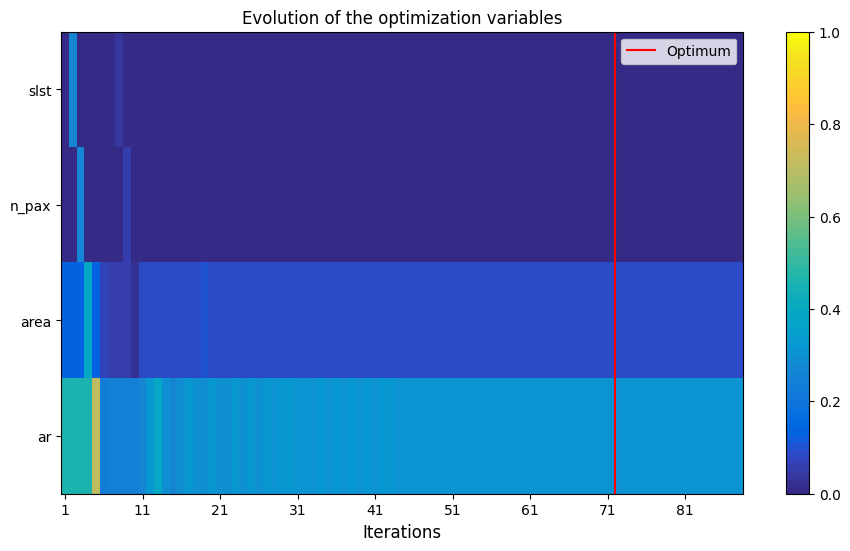

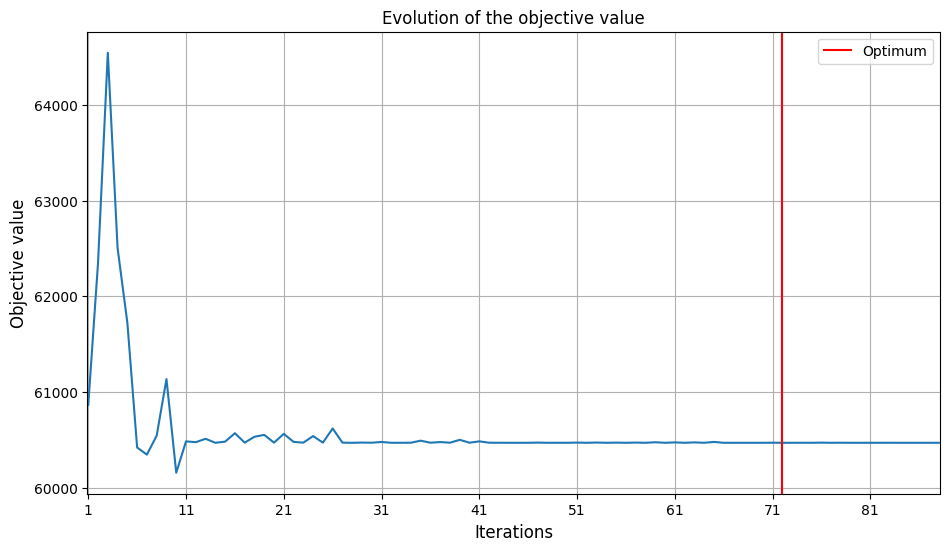

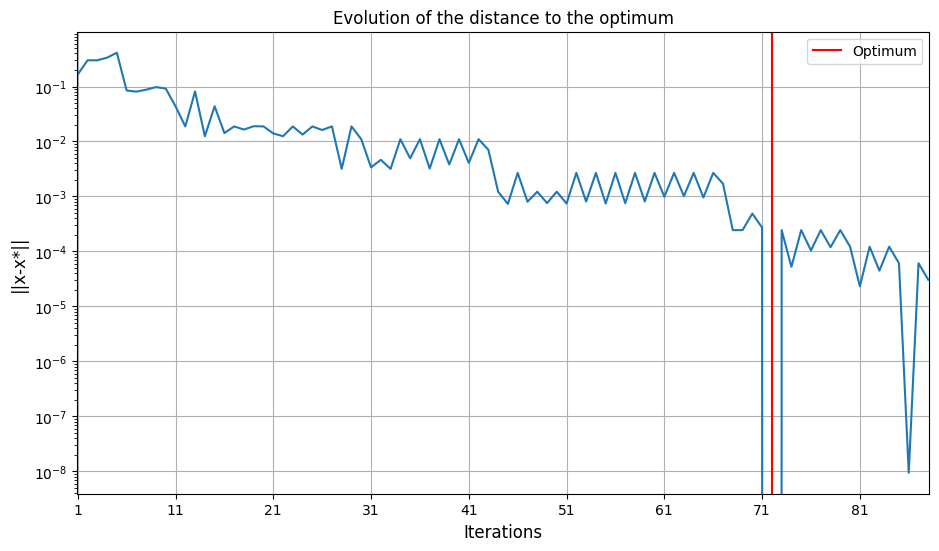

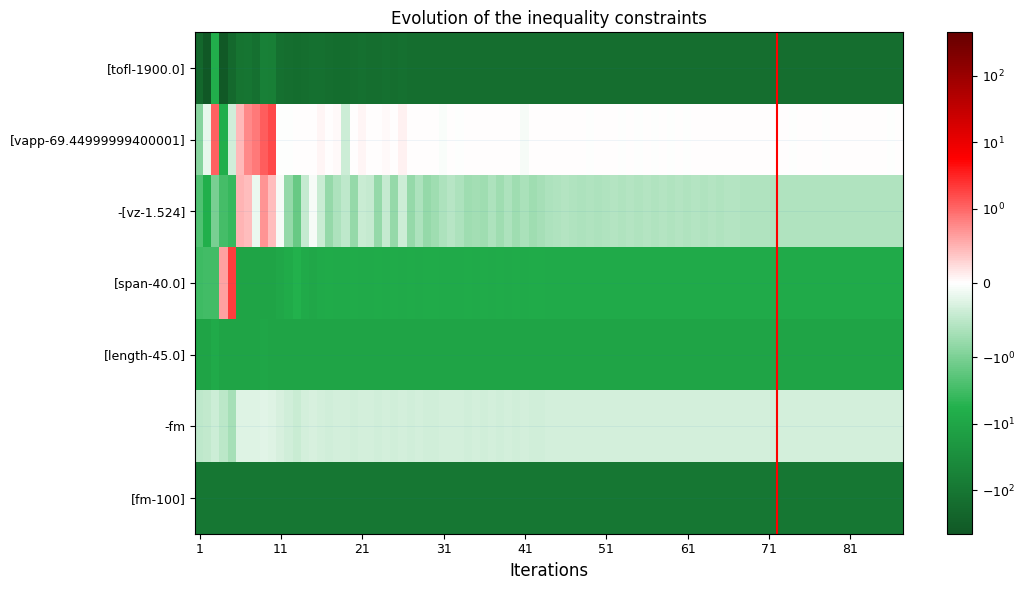

In [35]:
scenario_surrogate.post_process(post_name="OptHistoryView", save=False, show=True)

In [36]:
r2 = surrogate_discipline.get_error_measure("R2Measure")

In [37]:
r2.compute_cross_validation_measure(as_dict=True)

{'fm': array([0.99061011]),
 'length': array([1.]),
 'mtom': array([0.99707667]),
 'span': array([0.99661798]),
 'tofl': array([0.90118361]),
 'vapp': array([0.97944932]),
 'vz': array([0.98084194])}

In [38]:
r2.compute_test_measure(test_dataset, as_dict=True)

{'fm': array([0.99497524]),
 'length': array([1.]),
 'mtom': array([0.99404777]),
 'span': array([0.99839314]),
 'tofl': array([0.92994657]),
 'vapp': array([0.99712017]),
 'vz': array([0.95167482])}

In [39]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")

In [40]:
rmse.compute_learning_measure(as_dict=True)

{'fm': array([0.01603058]),
 'length': array([8.40725503e-15]),
 'mtom': array([621.48161236]),
 'span': array([0.08047483]),
 'tofl': array([60.6237532]),
 'vapp': array([0.29440953]),
 'vz': array([0.90400068])}

In [41]:
design_space_pb1

Name,Lower bound,Value,Upper bound,Type
slst,100000,100000,200000,float
n_pax,120,120,180,float
area,100,108.9878940567017,200,float
ar,5,9.638092857968783,20,float


In [42]:
#Vérification si le x optimal vérifie les contraintes (possible que non avec le model surrogate)
scenario.execute(algo_name="CustomDOE", samples=scenario_surrogate.optimization_result.x_opt.reshape(1, -1))

    INFO - 17:28:08: *** Start MDOScenario execution ***
    INFO - 17:28:08: MDOScenario
    INFO - 17:28:08:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:28:08:    MDO formulation: MDF
    INFO - 17:28:08: Optimization problem:
    INFO - 17:28:08:    minimize mtom(slst, n_pax, area, ar)
    INFO - 17:28:08:    with respect to ar, area, n_pax, slst
    INFO - 17:28:08:    subject to constraints:
    INFO - 17:28:08:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 17:28:08:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 17:28:08:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 17:28:08:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 17:28:08:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 17:28:08:       fm(slst, n_pax, area, ar) >= 0
    INFO - 17:28:08:       fm(slst, n_pax, area, ar) <= 100
    INFO - 17:28:08:    over the design space:
    INFO 

In [ ]:
from gemseo_oad_training.utils import draw_aircraft
dict_result = scenario_surrogate.optimization_result.x_opt_as_dict
import re
length_val = None
span_val = None

for key, val in scenario_surrogate.optimization_result.constraint_values.items():
    match = re.search(r'\[(\w+)-([\d.]+)\]', key)
    if match:
        var_name, constraint_str = match.groups()
        constraint = float(constraint_str)
        real_value = val + constraint  # valeur réelle = valeur + contrainte
        if var_name == "length":
            length_val = real_value
        elif var_name == "span":
            span_val = real_value

length_mean = length_val if length_val else None
span_mean = span_val if span_val else None

print("Valeur réelle moyenne de length :", length_val)
print("Valeur réelle moyenne de span   :", span_val)

ImportError: cannot import name 'draw_aircraft' from 'gemseo_oad_training.utils' (/home/n7student/2A/lh2pac/.venv/lib/python3.10/site-packages/gemseo_oad_training/utils.py)

In [ ]:
draw_aircraft(area=dict_result["area"][0],slst=dict_result["slst"][0], n_pax=dict_result["n_pax"][0],length=length_val, span=span_val, title="Résultat final")